In [85]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [60]:
travel_train = pd.read_csv("Traveldata_train.csv")
travel_test = pd.read_csv("Traveldata_test.csv")
survey_train = pd.read_csv("Surveydata_train.csv")
survey_test = pd.read_csv("Surveydata_test.csv")

# TRAVEL TRAIN EDA

In [61]:
travel_train.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,Female,Loyal Customer,52.00,NaN,Business,272,0.00,5.00
1,98800002,Male,Loyal Customer,48.00,Personal Travel,Eco,2200,9.00,0.00
2,98800003,Female,Loyal Customer,43.00,Business Travel,Business,1061,77.00,119.00
3,98800004,Female,Loyal Customer,44.00,Business Travel,Business,780,13.00,18.00
4,98800005,Female,Loyal Customer,50.00,Business Travel,Business,1981,0.00,0.00


In [62]:
travel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


In [63]:
travel_train.nunique()

ID                         94379
Gender                         2
Customer_Type                  2
Age                           75
Type_Travel                    2
Travel_Class                   2
Travel_Distance             5210
Departure_Delay_in_Mins      437
Arrival_Delay_in_Mins        434
dtype: int64

In [64]:
travel_train.isnull().any()

ID                         False
Gender                      True
Customer_Type               True
Age                         True
Type_Travel                 True
Travel_Class               False
Travel_Distance            False
Departure_Delay_in_Mins     True
Arrival_Delay_in_Mins       True
dtype: bool

In [65]:
num_cols = ["Age","Travel_Distance","Departure_Delay_in_Mins","Arrival_Delay_in_Mins"]
cat_cols = ["Gender","Customer_Type","Type_Travel","Travel_Class"]

In [66]:
travel_train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,94346.00,39.42,15.12,7.00,27.00,40.00,51.00,85.00
Travel_Distance,94379.00,1978.89,1027.96,50.00,1359.00,1923.00,2538.00,6951.00
Departure_Delay_in_Mins,94322.00,14.65,38.14,0.00,0.00,0.00,12.00,1592.00
Arrival_Delay_in_Mins,94022.00,15.01,38.44,0.00,0.00,0.00,13.00,1584.00


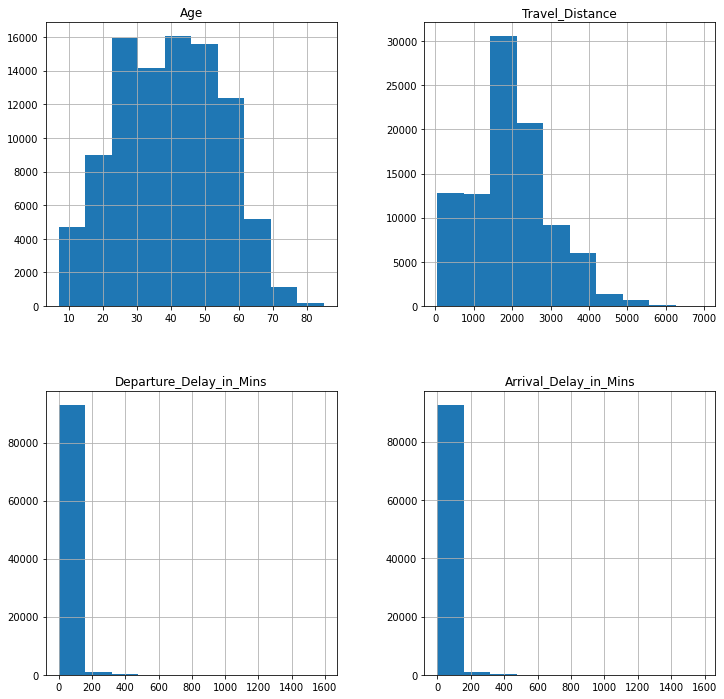

In [67]:
travel_train[num_cols].hist(figsize = (12,12))
plt.show()

In [68]:
for i in cat_cols:
    print(travel_train[i].value_counts(normalize=True))
    print("="*30)

Female   0.51
Male     0.49
Name: Gender, dtype: float64
Loyal Customer      0.82
Disloyal Customer   0.18
Name: Customer_Type, dtype: float64
Business Travel   0.69
Personal Travel   0.31
Name: Type_Travel, dtype: float64
Eco        0.52
Business   0.48
Name: Travel_Class, dtype: float64


# MERGING SURVEY AND TRAVEL TRAIN

In [69]:
merged_train = pd.merge(travel_train,survey_train,how="inner",on="ID")
merged_test = pd.merge(travel_test,survey_test,how = "inner",on ="ID")

# DATA HEAD

In [70]:
merged_train.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,Female,Loyal Customer,52.00,NaN,Business,272,0.00,5.00,0,...,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,Male,Loyal Customer,48.00,Personal Travel,Eco,2200,9.00,0.00,0,...,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,Female,Loyal Customer,43.00,Business Travel,Business,1061,77.00,119.00,1,...,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent
3,98800004,Female,Loyal Customer,44.00,Business Travel,Business,780,13.00,18.00,0,...,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable
4,98800005,Female,Loyal Customer,50.00,Business Travel,Business,1981,0.00,0.00,1,...,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good


In [71]:
merged_test.head()

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,99900001,Female,NaN,36.00,Business Travel,Business,532,0.00,0.00,Acceptable,...,Needs Improvement,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Poor
1,99900002,Female,Disloyal Customer,21.00,Business Travel,Business,1425,9.00,28.00,Extremely Poor,...,Acceptable,Poor,Acceptable,Acceptable,Excellent,Acceptable,Good,Acceptable,Excellent,Acceptable
2,99900003,Male,Loyal Customer,60.00,Business Travel,Business,2832,0.00,0.00,Excellent,...,Excellent,Excellent,Excellent,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Needs Improvement,Excellent
3,99900004,Female,Loyal Customer,29.00,Personal Travel,Eco,1352,0.00,0.00,Acceptable,...,Poor,Acceptable,Excellent,Poor,Acceptable,Needs Improvement,Excellent,Excellent,Excellent,Poor
4,99900005,Male,Disloyal Customer,18.00,Business Travel,Business,1610,17.00,0.00,Excellent,...,Excellent,Excellent,Excellent,Excellent,NaN,Acceptable,Excellent,Excellent,Excellent,Excellent


# DATASET INFO

In [72]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
 9   Overall_Experience       94379 non-null  int64  
 10  Seat_Comfort             94318 non-null  object 
 11  Seat_Class               94379 non-null  object 
 12  Arrival_Time_Convenient  85449 non-null  object 
 13  Catering                 85638 non-null  object 
 14  Platform_Location     

In [73]:
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35602 entries, 0 to 35601
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       35602 non-null  int64  
 1   Gender                   35572 non-null  object 
 2   Customer_Type            32219 non-null  object 
 3   Age                      35591 non-null  float64
 4   Type_Travel              32154 non-null  object 
 5   Travel_Class             35602 non-null  object 
 6   Travel_Distance          35602 non-null  int64  
 7   Departure_Delay_in_Mins  35573 non-null  float64
 8   Arrival_Delay_in_Mins    35479 non-null  float64
 9   Seat_Comfort             35580 non-null  object 
 10  Seat_Class               35602 non-null  object 
 11  Arrival_Time_Convenient  32277 non-null  object 
 12  Catering                 32245 non-null  object 
 13  Platform_Location        35590 non-null  object 
 14  Onboard_Wifi_Service  

In [74]:
merged_train = merged_train.drop(["ID"],axis = 1)
merged_test = merged_test.drop(["ID"],axis = 1)

In [75]:
num_cols = ["Age","Travel_Distance","Departure_Delay_in_Mins","Arrival_Delay_in_Mins"]
cat_cols = ["Gender","Customer_Type","Type_Travel","Travel_Class","Seat_Comfort","Seat_Class","Arrival_Time_Convenient",
            "Catering","Platform_Location","Onboard_Wifi_Service","Onboard_Entertainment","Online_Support","Ease_of_Online_Booking",
            "Onboard_Service","Legroom","Baggage_Handling","CheckIn_Service","Cleanliness","Online_Boarding","Overall_Experience"
           ]

# UNIQUE COUNT

In [76]:
merged_train.nunique()

Gender                        2
Customer_Type                 2
Age                          75
Type_Travel                   2
Travel_Class                  2
Travel_Distance            5210
Departure_Delay_in_Mins     437
Arrival_Delay_in_Mins       434
Overall_Experience            2
Seat_Comfort                  6
Seat_Class                    2
Arrival_Time_Convenient       6
Catering                      6
Platform_Location             6
Onboard_Wifi_Service          6
Onboard_Entertainment         6
Online_Support                6
Ease_of_Online_Booking        6
Onboard_Service               6
Legroom                       6
Baggage_Handling              5
CheckIn_Service               6
Cleanliness                   6
Online_Boarding               6
dtype: int64

In [77]:
merged_test.nunique()

Gender                        2
Customer_Type                 2
Age                          75
Type_Travel                   2
Travel_Class                  2
Travel_Distance            4644
Departure_Delay_in_Mins     350
Arrival_Delay_in_Mins       355
Seat_Comfort                  6
Seat_Class                    2
Arrival_Time_Convenient       6
Catering                      6
Platform_Location             5
Onboard_Wifi_Service          6
Onboard_Entertainment         6
Online_Support                5
Ease_of_Online_Booking        6
Onboard_Service               5
Legroom                       6
Baggage_Handling              5
CheckIn_Service               5
Cleanliness                   5
Online_Boarding               6
dtype: int64

In [78]:
for i in cat_cols:
    print(merged_train[i].value_counts())
    print("\n")
    print("="*25)

Female    47815
Male      46487
Name: Gender, dtype: int64


Loyal Customer       69823
Disloyal Customer    15605
Name: Customer_Type, dtype: int64


Business Travel    58617
Personal Travel    26536
Name: Type_Travel, dtype: int64


Eco         49342
Business    45037
Name: Travel_Class, dtype: int64


Acceptable           21158
Needs Improvement    20946
Good                 20595
Poor                 15185
Excellent            12971
Extremely Poor        3463
Name: Seat_Comfort, dtype: int64


Green Car    47435
Ordinary     46944
Name: Seat_Class, dtype: int64


Good                 19574
Excellent            17684
Acceptable           15177
Needs Improvement    14990
Poor                 13692
Extremely Poor        4332
Name: Arrival_Time_Convenient, dtype: int64


Acceptable           18468
Needs Improvement    17978
Good                 17969
Poor                 13858
Excellent            13455
Extremely Poor        3910
Name: Catering, dtype: int64


Manageable           2417

In [79]:
for i in cat_cols:
    if i != "Overall_Experience":
        print(merged_test[i].value_counts())
        print("\n")
        print("="*25)

Female    18069
Male      17503
Name: Gender, dtype: int64


Loyal Customer       26349
Disloyal Customer     5870
Name: Customer_Type, dtype: int64


Business Travel    22313
Personal Travel     9841
Name: Type_Travel, dtype: int64


Eco         18473
Business    17129
Name: Travel_Class, dtype: int64


Acceptable           8003
Needs Improvement    7831
Good                 7808
Poor                 5755
Excellent            4854
Extremely Poor       1329
Name: Seat_Comfort, dtype: int64


Ordinary     17860
Green Car    17742
Name: Seat_Class, dtype: int64


Good                 7361
Excellent            6589
Acceptable           5844
Needs Improvement    5684
Poor                 5131
Extremely Poor       1668
Name: Arrival_Time_Convenient, dtype: int64


Acceptable           7133
Needs Improvement    6701
Good                 6701
Poor                 5178
Excellent            5025
Extremely Poor       1507
Name: Catering, dtype: int64


Manageable           9364
Convenient       

In [80]:
merged_train.shape

(94379, 24)

In [81]:
for i in ["Cleanliness","CheckIn_Service","Onboard_Service","Online_Support","Platform_Location"]:
    if i != "Platform_Location":
        merged_train = merged_train[merged_train[i] != "Extremely Poor"]
    else:
        merged_train = merged_train[merged_train[i] != "Very Inconvenient"]

In [82]:
merged_train.shape

(94371, 24)

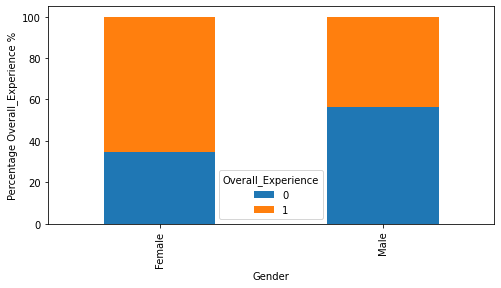

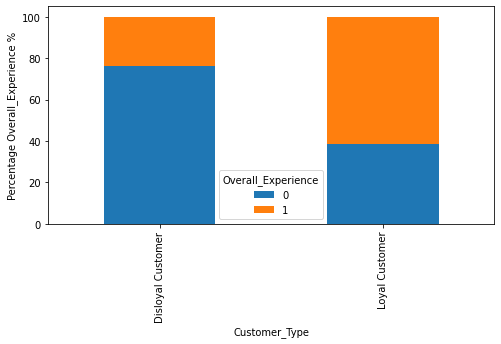

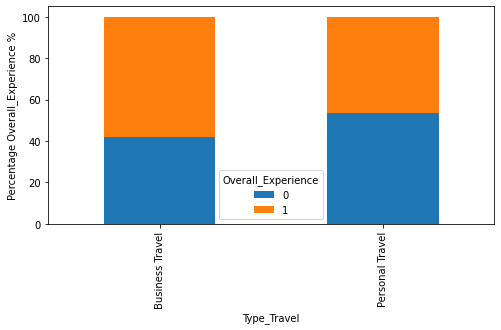

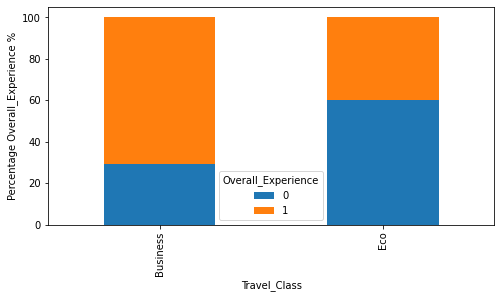

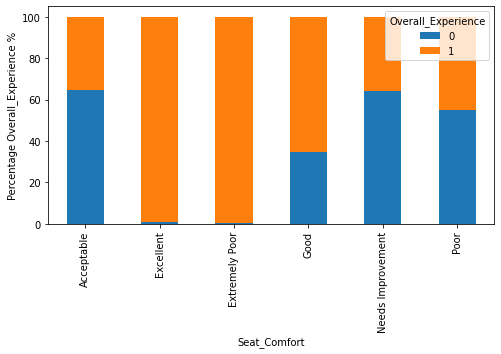

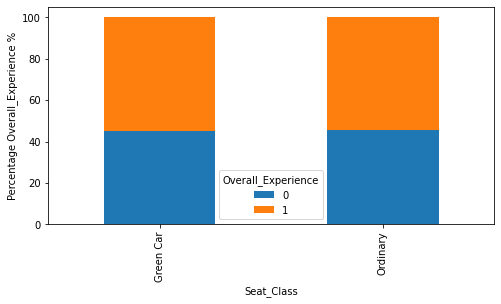

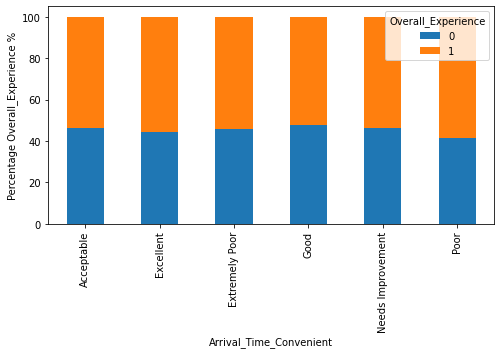

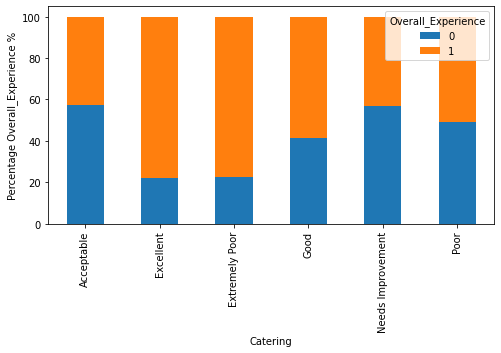

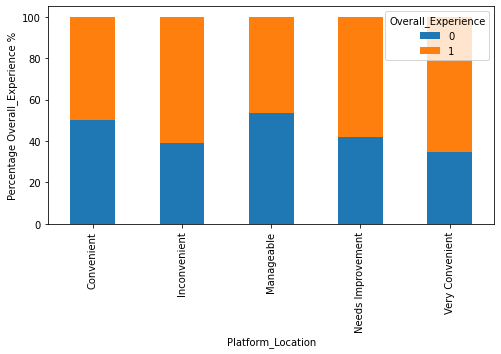

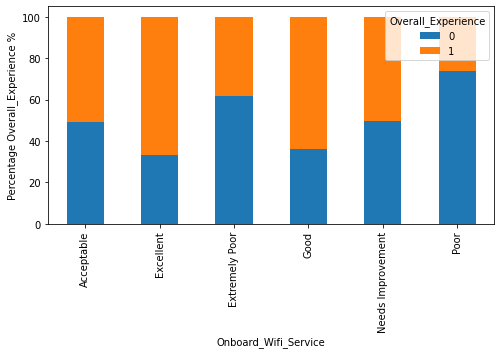

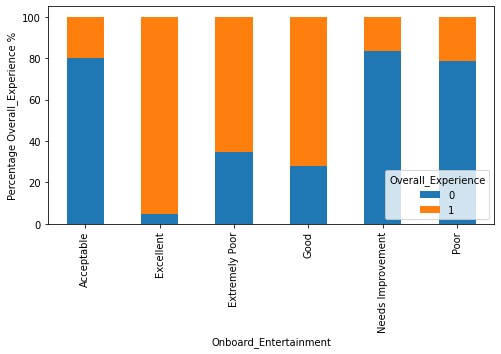

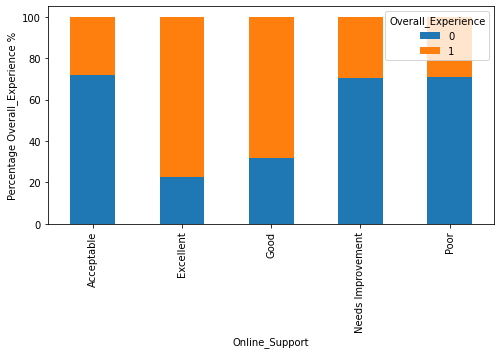

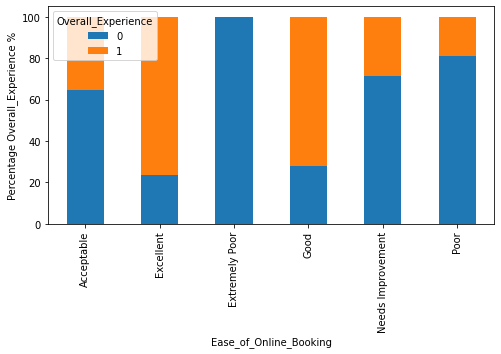

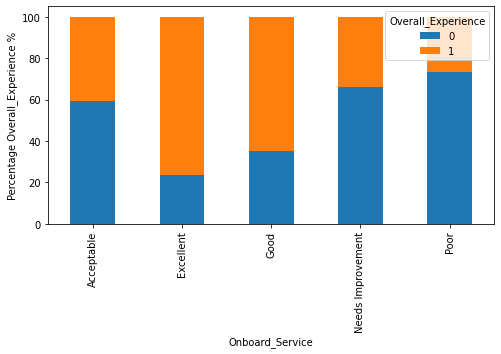

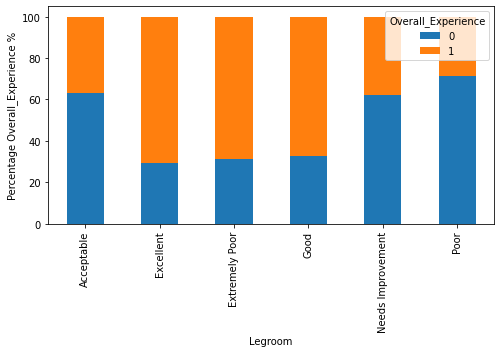

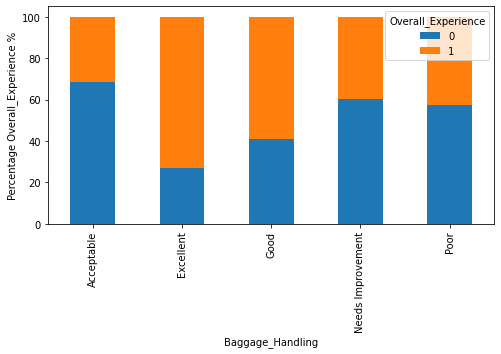

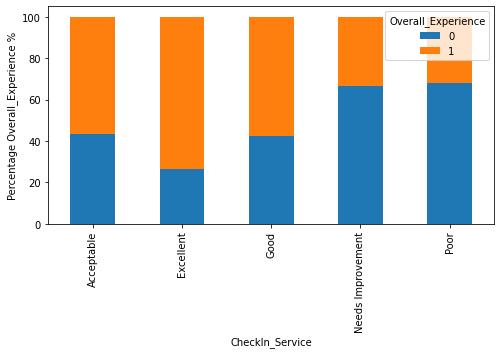

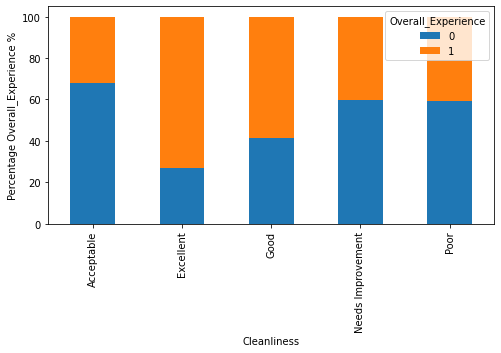

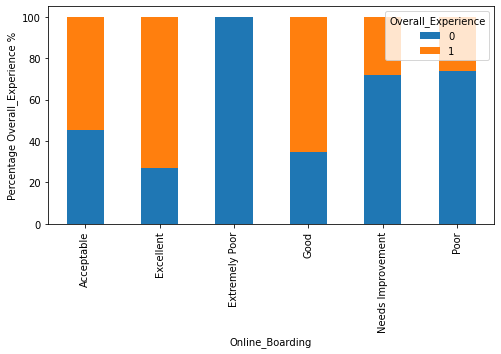

In [83]:
for i in cat_cols:
    if i!='Overall_Experience':
        (pd.crosstab(merged_train[i],merged_train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
        plt.ylabel('Percentage Overall_Experience %')

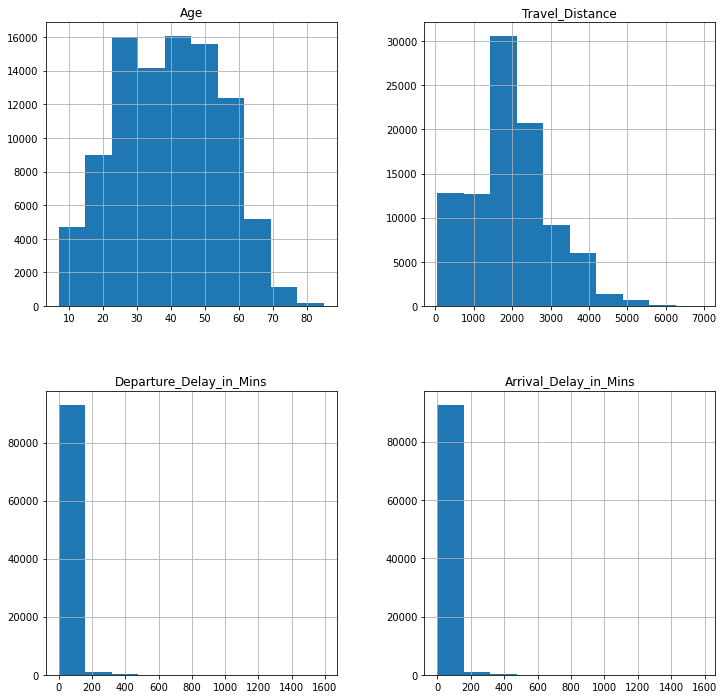

In [84]:
merged_train[num_cols].hist(figsize=(12,12))
plt.show()

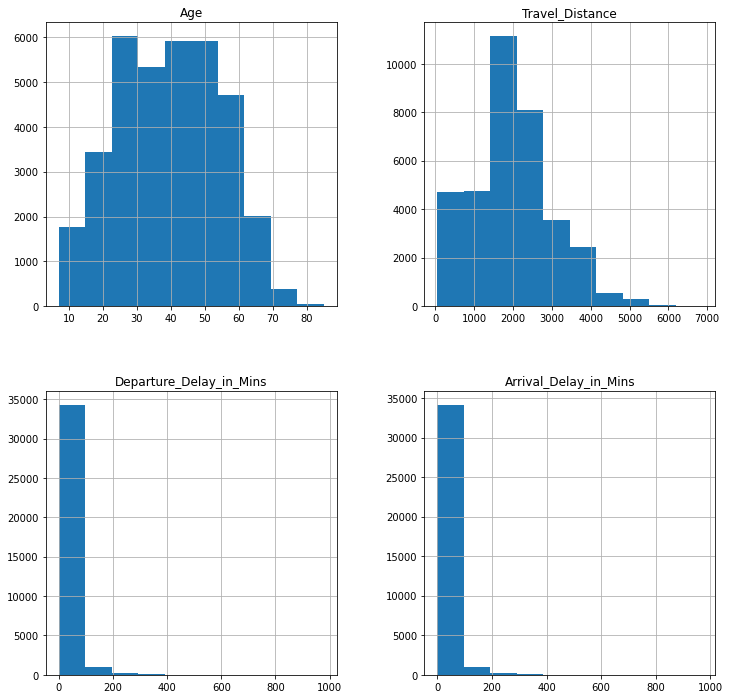

In [27]:
merged_test[num_cols].hist(figsize=(12,12))
plt.show()

In [28]:
merged_train_log = merged_train.copy()
merged_test_log = merged_test.copy()
for i in num_cols:
    merged_train_log[i] = merged_train_log[i].fillna(merged_train_log[i].mean())
for i in num_cols:
    merged_test_log[i] = merged_test_log[i].fillna(merged_test_log[i].mean())
merged_train_log["Arrival_Delay_in_Mins"] = [np.log(x) if x!=0 else x for x in merged_train_log["Arrival_Delay_in_Mins"]]
merged_train_log["Departure_Delay_in_Mins"] = [np.log(x) if x!=0 else x for x in merged_train_log["Departure_Delay_in_Mins"]]
merged_test_log["Arrival_Delay_in_Mins"] = [np.log(x) if x!=0 else x for x in merged_test_log["Arrival_Delay_in_Mins"]]
merged_test_log["Departure_Delay_in_Mins"] = [np.log(x) if x!=0 else x for x in merged_test_log["Departure_Delay_in_Mins"]]

In [29]:
merged_train_log.isnull().any()

Gender                      True
Customer_Type               True
Age                        False
Type_Travel                 True
Travel_Class               False
Travel_Distance            False
Departure_Delay_in_Mins    False
Arrival_Delay_in_Mins      False
Overall_Experience         False
Seat_Comfort                True
Seat_Class                 False
Arrival_Time_Convenient     True
Catering                    True
Platform_Location           True
Onboard_Wifi_Service        True
Onboard_Entertainment       True
Online_Support              True
Ease_of_Online_Booking      True
Onboard_Service             True
Legroom                     True
Baggage_Handling            True
CheckIn_Service             True
Cleanliness                 True
Online_Boarding             True
dtype: bool

In [30]:
merged_test_log.isnull().any()

Gender                      True
Customer_Type               True
Age                        False
Type_Travel                 True
Travel_Class               False
Travel_Distance            False
Departure_Delay_in_Mins    False
Arrival_Delay_in_Mins      False
Seat_Comfort                True
Seat_Class                 False
Arrival_Time_Convenient     True
Catering                    True
Platform_Location           True
Onboard_Wifi_Service        True
Onboard_Entertainment       True
Online_Support              True
Ease_of_Online_Booking      True
Onboard_Service             True
Legroom                     True
Baggage_Handling            True
CheckIn_Service             True
Cleanliness                 True
Online_Boarding             True
dtype: bool

In [31]:
for i in cat_cols:
    merged_train_log[i] = merged_train_log[i].fillna(merged_train_log[i].mode()[0])
for i in cat_cols:
    if i != "Overall_Experience":
        merged_test_log[i] = merged_test_log[i].fillna(merged_test_log[i].mode()[0])

In [32]:
merged_train_log.isnull().any()

Gender                     False
Customer_Type              False
Age                        False
Type_Travel                False
Travel_Class               False
Travel_Distance            False
Departure_Delay_in_Mins    False
Arrival_Delay_in_Mins      False
Overall_Experience         False
Seat_Comfort               False
Seat_Class                 False
Arrival_Time_Convenient    False
Catering                   False
Platform_Location          False
Onboard_Wifi_Service       False
Onboard_Entertainment      False
Online_Support             False
Ease_of_Online_Booking     False
Onboard_Service            False
Legroom                    False
Baggage_Handling           False
CheckIn_Service            False
Cleanliness                False
Online_Boarding            False
dtype: bool

In [33]:
merged_test_log.isnull().any()

Gender                     False
Customer_Type              False
Age                        False
Type_Travel                False
Travel_Class               False
Travel_Distance            False
Departure_Delay_in_Mins    False
Arrival_Delay_in_Mins      False
Seat_Comfort               False
Seat_Class                 False
Arrival_Time_Convenient    False
Catering                   False
Platform_Location          False
Onboard_Wifi_Service       False
Onboard_Entertainment      False
Online_Support             False
Ease_of_Online_Booking     False
Onboard_Service            False
Legroom                    False
Baggage_Handling           False
CheckIn_Service            False
Cleanliness                False
Online_Boarding            False
dtype: bool

In [34]:
merged_train_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94371 entries, 0 to 94378
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   94371 non-null  object 
 1   Customer_Type            94371 non-null  object 
 2   Age                      94371 non-null  float64
 3   Type_Travel              94371 non-null  object 
 4   Travel_Class             94371 non-null  object 
 5   Travel_Distance          94371 non-null  int64  
 6   Departure_Delay_in_Mins  94371 non-null  float64
 7   Arrival_Delay_in_Mins    94371 non-null  float64
 8   Overall_Experience       94371 non-null  int64  
 9   Seat_Comfort             94371 non-null  object 
 10  Seat_Class               94371 non-null  object 
 11  Arrival_Time_Convenient  94371 non-null  object 
 12  Catering                 94371 non-null  object 
 13  Platform_Location        94371 non-null  object 
 14  Onboard_Wifi_Service  

In [35]:
merged_test_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35602 entries, 0 to 35601
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   35602 non-null  object 
 1   Customer_Type            35602 non-null  object 
 2   Age                      35602 non-null  float64
 3   Type_Travel              35602 non-null  object 
 4   Travel_Class             35602 non-null  object 
 5   Travel_Distance          35602 non-null  int64  
 6   Departure_Delay_in_Mins  35602 non-null  float64
 7   Arrival_Delay_in_Mins    35602 non-null  float64
 8   Seat_Comfort             35602 non-null  object 
 9   Seat_Class               35602 non-null  object 
 10  Arrival_Time_Convenient  35602 non-null  object 
 11  Catering                 35602 non-null  object 
 12  Platform_Location        35602 non-null  object 
 13  Onboard_Wifi_Service     35602 non-null  object 
 14  Onboard_Entertainment 

In [36]:
merged_train_log.head()

,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,Seat_Comfort,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,Female,Loyal Customer,52.00,Business Travel,Business,272,0.00,1.61,0,Needs Improvement,...,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,Male,Loyal Customer,48.00,Personal Travel,Eco,2200,2.20,0.00,0,Poor,...,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,Female,Loyal Customer,43.00,Business Travel,Business,1061,4.34,4.78,1,Needs Improvement,...,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent
3,Female,Loyal Customer,44.00,Business Travel,Business,780,2.56,2.89,0,Acceptable,...,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable
4,Female,Loyal Customer,50.00,Business Travel,Business,1981,0.00,0.00,1,Acceptable,...,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good


In [37]:
merged_train_log_encoded = merged_train_log.copy()
merged_test_log_encoded = merged_test_log.copy()

scale_mapper = {
    "Extremely Poor" : 0,
    "Poor" : 1,
    "Needs Improvement" : 2,
    "Acceptable":3,
    "Good":4,
    "Excellent":5
}

In [38]:
merged_train_log_encoded = merged_train_log_encoded.replace(scale_mapper)
merged_test_log_encoded = merged_test_log_encoded.replace(scale_mapper)

In [39]:
platform_mapper = {
    "Very Inconvenient" : 0,
    "Inconvenient" : 1,
    "Needs Improvement" : 2,
    "Manageable" : 3,
    "Convenient" :4,
    "Very Convenient" :5,
}

travel_class_mapper = {
    "Eco" : 0,
    "Business" : 1
}

In [40]:
merged_train_log_encoded = merged_train_log_encoded.replace(platform_mapper)
merged_train_log_encoded = merged_train_log_encoded.replace(travel_class_mapper)
merged_test_log_encoded = merged_test_log_encoded.replace(platform_mapper)
merged_test_log_encoded = merged_test_log_encoded.replace(travel_class_mapper)

In [41]:
merged_train_log_encoded

,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,Seat_Comfort,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,Female,Loyal Customer,52.00,Business Travel,1,272,0.00,1.61,0,2,...,4,2,3,2,2,3,2,4,2,1
1,Male,Loyal Customer,48.00,Personal Travel,0,2200,2.20,0.00,0,1,...,4,1,4,4,5,2,1,2,4,4
2,Female,Loyal Customer,43.00,Business Travel,1,1061,4.34,4.78,1,2,...,2,4,5,5,5,5,5,4,5,5
3,Female,Loyal Customer,44.00,Business Travel,1,780,2.56,2.89,0,3,...,3,2,3,3,3,3,3,4,3,3
4,Female,Loyal Customer,50.00,Business Travel,1,1981,0.00,0.00,1,3,...,2,4,5,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94374,Male,Loyal Customer,32.00,Business Travel,1,1357,4.42,4.83,0,1,...,1,1,1,1,4,4,4,2,4,1
94375,Male,Loyal Customer,44.00,Business Travel,1,592,1.61,2.40,1,4,...,2,5,5,3,3,3,3,4,3,4
94376,Male,Loyal Customer,63.00,Business Travel,1,2794,0.00,0.00,1,2,...,4,5,4,4,4,4,4,3,4,3
94377,Male,Loyal Customer,16.00,Personal Travel,0,2744,0.00,0.00,0,2,...,4,2,4,4,3,4,4,4,5,4


In [42]:
merged_test_log_encoded

,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Seat_Class,...,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,Female,Loyal Customer,36.00,Business Travel,1,532,0.00,0.00,3,Green Car,...,2,5,4,5,5,5,5,4,5,1
1,Female,Disloyal Customer,21.00,Business Travel,1,1425,2.20,3.33,0,Ordinary,...,3,1,3,3,5,3,4,3,5,3
2,Male,Loyal Customer,60.00,Business Travel,1,2832,0.00,0.00,5,Ordinary,...,5,5,5,2,2,2,2,4,2,5
3,Female,Loyal Customer,29.00,Personal Travel,0,1352,0.00,0.00,3,Green Car,...,1,3,5,1,3,2,5,5,5,1
4,Male,Disloyal Customer,18.00,Business Travel,1,1610,2.83,0.00,5,Ordinary,...,5,5,5,5,4,3,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,Male,Loyal Customer,8.00,Personal Travel,0,1334,0.00,0.00,2,Green Car,...,3,2,3,3,4,5,4,3,4,3
35598,Female,Loyal Customer,53.00,Business Travel,1,1772,0.00,0.00,2,Ordinary,...,3,5,5,4,4,4,4,3,4,4
35599,Male,Disloyal Customer,22.00,Business Travel,0,1180,0.00,0.00,4,Green Car,...,2,4,1,2,1,3,1,1,5,2
35600,Female,Loyal Customer,67.00,Personal Travel,0,420,3.14,2.77,5,Ordinary,...,3,5,4,5,5,5,5,3,5,4


# MODEL BUILDING APPROACH

In [43]:
df_train_wo_selection = merged_train_log_encoded.copy()
df_test_wo_selection = merged_test_log_encoded.copy()
to_get_dummies_for = ["Gender","Customer_Type","Type_Travel","Travel_Class","Seat_Class"]

df_train_wo_selection = pd.get_dummies(data = df_train_wo_selection, columns = to_get_dummies_for, drop_first = True)
df_test_wo_selection = pd.get_dummies(data = df_test_wo_selection, columns = to_get_dummies_for, drop_first = True)
df_train_wo_selection.head()

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,Seat_Comfort,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,...,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Gender_Male,Customer_Type_Loyal Customer,Type_Travel_Personal Travel,Travel_Class_1,Seat_Class_Ordinary
0,52.00,272,0.00,1.61,0,2,5,5,5,4,...,3,2,4,2,1,0,1,0,1,0
1,48.00,2200,2.20,0.00,0,1,5,1,2,4,...,2,1,2,4,4,1,1,1,0,1
2,43.00,1061,4.34,4.78,1,2,2,2,2,2,...,5,5,4,5,5,0,1,0,1,0
3,44.00,780,2.56,2.89,0,3,2,3,2,3,...,3,3,4,3,3,0,1,0,1,1
4,50.00,1981,0.00,0.00,1,3,3,3,3,2,...,4,4,4,4,4,0,1,0,1,1


In [44]:
df_test_wo_selection.head()

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,...,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Gender_Male,Customer_Type_Loyal Customer,Type_Travel_Personal Travel,Travel_Class_1,Seat_Class_Ordinary
0,36.00,532,0.00,0.00,3,3,3,3,2,5,...,5,5,4,5,1,0,1,0,1,0
1,21.00,1425,2.20,3.33,0,4,1,3,3,1,...,3,4,3,5,3,0,0,0,1,1
2,60.00,2832,0.00,0.00,5,5,5,5,5,5,...,2,2,4,2,5,1,1,0,1,1
3,29.00,1352,0.00,0.00,3,5,3,5,1,3,...,2,5,5,5,1,0,1,1,0,0
4,18.00,1610,2.83,0.00,5,0,5,2,5,5,...,3,5,5,5,5,1,0,0,1,1


In [45]:
Y_train = df_train_wo_selection["Overall_Experience"]
X_train = df_train_wo_selection.drop(columns=["Overall_Experience"])
X_test = df_test_wo_selection.copy()

In [46]:
chi2_selector = SelectKBest(chi2, k = 16)
features_best = chi2_selector.fit_transform(X_train,Y_train)

In [47]:
cols = chi2_selector.get_support(indices=True)
X_train = X_train.iloc[:,cols]
X_test = X_test.iloc[:,cols]

In [48]:
X_train

,Age,Travel_Distance,Arrival_Delay_in_Mins,Seat_Comfort,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Gender_Male,Travel_Class_1
0,52.00,272,1.61,2,4,2,3,2,2,3,2,4,2,1,0,1
1,48.00,2200,0.00,1,4,1,4,4,5,2,1,2,4,4,1,0
2,43.00,1061,4.78,2,2,4,5,5,5,5,5,4,5,5,0,1
3,44.00,780,2.89,3,3,2,3,3,3,3,3,4,3,3,0,1
4,50.00,1981,0.00,3,2,4,5,4,4,4,4,4,4,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94374,32.00,1357,4.83,1,1,1,1,1,4,4,4,2,4,1,1,1
94375,44.00,592,2.40,4,2,5,5,3,3,3,3,4,3,4,1,1
94376,63.00,2794,0.00,2,4,5,4,4,4,4,4,3,4,3,1,1
94377,16.00,2744,0.00,2,4,2,4,4,3,4,4,4,5,4,1,0


In [49]:
X_test

,Age,Travel_Distance,Arrival_Delay_in_Mins,Seat_Comfort,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Gender_Male,Travel_Class_1
0,36.00,532,0.00,3,2,5,4,5,5,5,5,4,5,1,0,1
1,21.00,1425,3.33,0,3,1,3,3,5,3,4,3,5,3,0,1
2,60.00,2832,0.00,5,5,5,5,2,2,2,2,4,2,5,1,1
3,29.00,1352,0.00,3,1,3,5,1,3,2,5,5,5,1,0,0
4,18.00,1610,0.00,5,5,5,5,5,4,3,5,5,5,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,8.00,1334,0.00,2,3,2,3,3,4,5,4,3,4,3,1,0
35598,53.00,1772,0.00,2,3,5,5,4,4,4,4,3,4,4,0,1
35599,22.00,1180,0.00,4,2,4,1,2,1,3,1,1,5,2,1,0
35600,67.00,420,2.77,5,3,5,4,5,5,5,5,3,5,4,0,0


In [49]:
sc = StandardScaler()
continuous_scaled = sc.fit_transform(X_train.iloc[:,:2])

In [487]:
X_train_scaled = np.concatenate([continuous_scaled,X_train.iloc[:,4:].values],axis = 1)
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns

In [55]:
X_train

,Age,Travel_Distance,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking
0,52.00,272,2,3,2
1,48.00,2200,1,4,4
2,43.00,1061,4,5,5
3,44.00,780,2,3,3
4,50.00,1981,4,5,4
...,...,...,...,...,...
94374,32.00,1357,1,1,1
94375,44.00,592,5,5,3
94376,63.00,2794,5,4,4
94377,16.00,2744,2,4,4


In [53]:
# Creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Attrite', 'Attrite'], yticklabels=['Not Attrite', 'Attrite'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# RANDOM FOREST BASED

In [51]:
# Fitting the Random Forest classifier on the training data
rf_estimator = RandomForestClassifier(random_state = 1,n_jobs=-1)

rf_estimator.fit(X_train, Y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42780
           1       1.00      1.00      1.00     51591

    accuracy                           1.00     94371
   macro avg       1.00      1.00      1.00     94371
weighted avg       1.00      1.00      1.00     94371



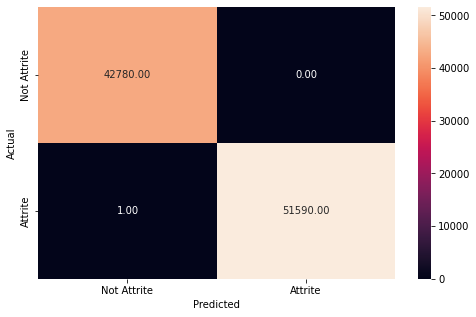

In [52]:
# Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(X_train)

metrics_score(Y_train, y_pred_train_rf)

# RANDOM FOREST TUNED

In [50]:
PARAMS = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}

rf_tuned = RandomForestClassifier(random_state=1,n_jobs=-1)

grid_rf_tuned = RandomizedSearchCV(estimator=rf_tuned,
                                   param_distributions=PARAMS,
                                   n_iter = 15, 
                                   cv = 3, 
                                   verbose=2, 
                                   random_state=1,
                                   n_jobs=-1)

grid_rf_tuned.fit(X_train,Y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=1, verbose=2)

In [51]:
grid_rf_tuned.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=40, max_features='auto',
                       n_estimators=600, n_jobs=-1, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42780
           1       1.00      1.00      1.00     51591

    accuracy                           1.00     94371
   macro avg       1.00      1.00      1.00     94371
weighted avg       1.00      1.00      1.00     94371



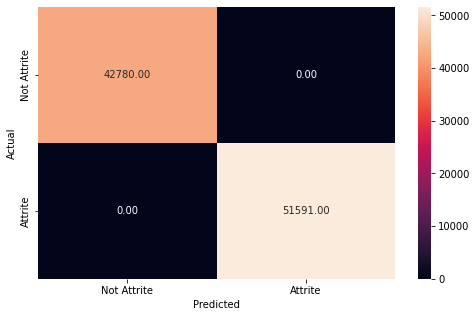

In [54]:
# Checking performance on the training data
y_pred_train_rf_tuned = grid_rf_tuned.predict(X_train)

metrics_score(Y_train, y_pred_train_rf_tuned)

In [55]:
y_pred_test_rf_tuned = grid_rf_tuned.predict(X_test)

# ADA BOOST

In [71]:
ada_boost_clf = AdaBoostClassifier(random_state=1)
ada_boost_clf.fit(X_train,Y_train)

AdaBoostClassifier(random_state=1)

              precision    recall  f1-score   support

           0       0.87      0.88      0.87     42780
           1       0.90      0.89      0.89     51591

    accuracy                           0.89     94371
   macro avg       0.88      0.88      0.88     94371
weighted avg       0.89      0.89      0.89     94371



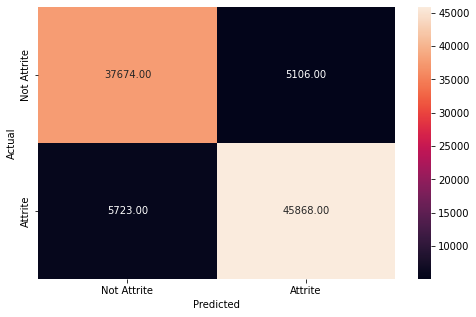

In [72]:
# Checking performance on the training data
y_pred_train_clf = ada_boost_clf.predict(X_train)

metrics_score(Y_train, y_pred_train_clf)

In [229]:
y_pred_test_rf = rf_estimator.predict(X_test)

In [230]:
y_pred = list(y_pred_test_rf)

# SAVING SUBMISSION

In [56]:
submission = pd.read_csv("Sample_Submission.csv")

In [57]:
submission["Overall_Experience"] = y_pred_test_rf_tuned

In [58]:
submission

,ID,Overall_Experience
0,99900001,1
1,99900002,1
2,99900003,1
3,99900004,0
4,99900005,1
...,...,...
35597,99935598,0
35598,99935599,1
35599,99935600,1
35600,99935601,1


In [197]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   ID                  35602 non-null  int64
 1   Overall_Experience  35602 non-null  int64
dtypes: int64(2)
memory usage: 556.4 KB


In [59]:
submission.to_csv("ferdio-nathaniel-2.csv",index=False)